## Supplier Risk MVP for Schmidt Medical Technology 

- Goal is to build a minimal, explainable quantitative risk score per supplier using the customer's ERP export. 
- Inputs: 5 CSVs (orders, suppliers, articles, addresses, indices)
- Outputs: tidy result table with "supplier_id", "country", "sum_of_oder_volume", "industry", "quantitative_ris_score" and some visuals
- Remark: all assumptions & weights are set in the CONFIG cell to ensure fast iteration

In [169]:
# Imports
import pandas as pd
import numpy as np
from dataclasses import asdict
import sys
from pathlib import Path
from src.utils import Config
from copy import deepcopy
import pycountry
import matplotlib.pyplot as plt

sys.path.append(str(Path("..").resolve()))  

# Paths
PROJ = Path("..").resolve() # moves one level up from notebooks folder (parent folder) 
DATA = PROJ / 'data' / 'raw' # portable path to input files
OUTPUT = PROJ / 'data' / 'output' # output csv file
REPORTS = PROJ / 'reports' # results/figures are saved here
REPORTS.mkdir(parents=True, exist_ok=True) # ensures folder exists to ensure figure/results saves

## Step 1: Load & preview CSVs

In [94]:
# Define file paths for all 5 datasets (stored in data/raw/)
FILES = {
    'addresses': DATA / 'addresses.csv',
    'articles': DATA / 'articles.csv',
    'indices': DATA / 'indices.csv',
    'orders': DATA / 'orders.csv',
    'suppliers': DATA / 'suppliers.csv',
}

# Load each existing CSV into a pandas dataframe (df)
# -> key = dataset name (string)
# -> value = corresponding df
dfs = {k: pd.read_csv(v) for k, v in FILES.items() if v.exists()}

# Preview the first 5 rows of each dataset and basic structure info
for name, df in dfs.items():
    print(f"\n--- {name.upper()} ---")
    display(df.head(5))  
    print(df.info())     # column dtypes, non-null counts, memory usage


--- ADDRESSES ---


,supplier_id,country
0,1003,Sweden
1,1084,Germany
2,1076,germany
3,1093,Germany
4,1037,germany


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   supplier_id  117 non-null    int64 
 1   country      117 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.0+ KB
None

--- ARTICLES ---


,Article_ID,Article,Industry
0,"""1000001""",Standardteile aus Aluminium,Metals
1,"""1000002""",Blechteile,metals
2,"""1000003""",Rohmetalle,Metals
3,"""1000004""",Elektronische Standardteile,Electronics
4,"""1000005""",Technische Produkte,electronics


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Article_ID  11 non-null     object
 1   Article     11 non-null     object
 2   Industry    11 non-null     object
dtypes: object(3)
memory usage: 392.0+ bytes
None

--- INDICES ---


,country_id,human_rights_index,enivronmental_risk
0,AFG,16.0,91.0
1,ALB,94.0,91.0
2,DZA,39.0,91.0
3,ASM,NaN,NaN
4,AND,NaN,91.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country_id          249 non-null    object 
 1   human_rights_index  142 non-null    float64
 2   enivronmental_risk  220 non-null    float64
dtypes: float64(2), object(1)
memory usage: 6.0+ KB
None

--- ORDERS ---


,order_id,price_per_quantity,quantity,order_value,supplier_id,article_id
0,O00107,470.33,92,43270.36,"""1001""",1000001
1,O00109,241.40,163,39348.20,"""1001""",1000001
2,O00112,357.63,7,2503.41,"""1001""",1000002
3,O00278,865.39,125,108173.75,"""1001""",1000002
4,O00300,889.69,58,51602.02,"""1001""",1000003


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   order_id            500 non-null    object 
 1   price_per_quantity  500 non-null    float64
 2   quantity            500 non-null    int64  
 3   order_value         500 non-null    float64
 4   supplier_id         500 non-null    object 
 5   article_id          500 non-null    int64  
dtypes: float64(2), int64(2), object(2)
memory usage: 23.6+ KB
None

--- SUPPLIERS ---


,supplier_id,total_company_revenue,domain,status,certificates_valid
0,1003,1.377955e+09,NaN,inactive,no
1,1084,1.074170e+09,NaN,active,yes
2,1076,9.030552e+08,NaN,active,yes
3,1093,7.450531e+08,NaN,active,yes
4,1037,1.700478e+09,NaN,inactive,yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106 entries, 0 to 105
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   supplier_id            106 non-null    int64  
 1   total_company_revenue  106 non-null    float64
 2   domain                 0 non-null      float64
 3   status                 106 non-null    object 
 4   certificates_valid     106 non-null    object 
dtypes: float64(2), int64(1), object(2)
memory usage: 4.3+ KB
None


## Step 2: Data Audit

In [95]:
# 1) Primary key (pk) uniqueness check 
# to ensure that pks do not have duplicates (could break joins & aggregations later)
pk_checks = {
    "addresses": "supplier_id", # expect one address per supplier
    "orders": "order_id",       # each order should have unique ID
    "articles": "Article_ID",   # each article should be unique
    "suppliers": "supplier_id", # each supplier should appear once
    "indices": "country_id",    # each country should appear once in indices
}
uniqueness = {}
for name, pk in pk_checks.items():
    dupe = dfs[name][pk].duplicated().sum()
    uniqueness[name] = {"pk": pk, "duplicates": int(dupe)}
uniqueness

{'addresses': {'pk': 'supplier_id', 'duplicates': 17},
 'orders': {'pk': 'order_id', 'duplicates': 0},
 'articles': {'pk': 'Article_ID', 'duplicates': 0},
 'suppliers': {'pk': 'supplier_id', 'duplicates': 6},
 'indices': {'pk': 'country_id', 'duplicates': 0}}

In [96]:
addr = dfs["addresses"]

# Find suppliers with multiple countries
multi_country = (
    addr.groupby("supplier_id")["country"]
    .nunique()
    .reset_index()
    .query("country > 1")
)

# Show suppliers and their countries
multi_country["countries"] = multi_country["supplier_id"].apply(
    lambda sid: addr.loc[addr["supplier_id"] == sid, "country"].unique().tolist()
)

multi_country

,supplier_id,country,countries
95,1096,2,"[Germany, germany]"


In [97]:
# Check duplicate supplier_ids in suppliers table
suppliers_df = dfs["suppliers"]

# Identify supplier_ids with more than one row
dup_sup_ids = suppliers_df["supplier_id"][suppliers_df["supplier_id"].duplicated()].unique()

# Show all rows for those supplier_ids
suppliers_duplicates = suppliers_df[suppliers_df["supplier_id"].isin(dup_sup_ids)]

display(suppliers_duplicates.sort_values("supplier_id"))

,supplier_id,total_company_revenue,domain,status,certificates_valid
32,1019,12187127.40,NaN,inactive,yes
33,1019,12187127.40,NaN,inactive,yes
34,1019,12187127.40,NaN,inactive,yes
11,1055,8295672.56,NaN,active,yes
12,1055,8295672.56,NaN,active,yes
90,1086,7725679.68,NaN,active,yes
91,1086,7725679.68,NaN,active,yes
92,1086,7725679.68,NaN,active,yes
18,1098,18603697.32,NaN,active,no
19,1098,18603697.32,NaN,active,no


#### Quick interpretation of PK uniqueness check: 
- 17 duplicates in supplier IDs: but as I analyzed, no supplier has multiple addresses
- 6 supplier duplicates: each supplier should likely have one record (can only take the first one since other values are the same)

In [98]:
# 2) Referential integrity
# checking whether all the foreign keys in one table have matching primary keays in the related table
# e.g.: every article_id in orders should exist in articles

ri = {}
orders = dfs["orders"]; articles = dfs["articles"]; suppliers = dfs["suppliers"]; addresses = dfs["addresses"]

# checking if each "x_id" in df y exists in the df z
ri["orders->articles"]  = (~orders["article_id"].isin(articles["Article_ID"])).mean()
ri["orders->suppliers"] = (~orders["supplier_id"].isin(suppliers["supplier_id"])).mean()
ri["addresses->suppliers"] = (~addresses["supplier_id"].isin(suppliers["supplier_id"])).mean()

# fraction of missing references (0.0 = perfect). Multiply by 100 for %
{k: round(v*100,2) for k,v in ri.items()}


{'orders->articles': 100.0,
 'orders->suppliers': 100.0,
 'addresses->suppliers': 0.0}

#### Interpretation of referential integrity: 
- orders->articles: 100001 vs. "100001" don't align
- orders->suppliers: "1001" vs. 1001 don't align 

In [99]:
# 3) Missingness in key columns
key_cols = [
    ("orders", ["order_id","price_per_quantity", "quantity","order_value","supplier_id","article_id"]),
    ("articles", ["Article_ID","Article","Industry"]),
    ("addresses", ["supplier_id","country"]),
    ("suppliers", ["supplier_id","total_company_revenue","domain","status","certificates_valid"]),
    ("indices", ["country_id","human_rights_index","enivronmental_risk"]),
]
miss = []
for name, cols in key_cols:
    for c in cols:
        miss.append({"dataset": name, "column": c, "null_%": round(dfs[name][c].isna().mean()*100,1)})
pd.DataFrame(miss).sort_values(["null_%","dataset"], ascending=[False,True])

,dataset,column,null_%
13,suppliers,domain,100.0
17,indices,human_rights_index,43.0
18,indices,enivronmental_risk,11.6
9,addresses,supplier_id,0.0
10,addresses,country,0.0
6,articles,Article_ID,0.0
7,articles,Article,0.0
8,articles,Industry,0.0
16,indices,country_id,0.0
0,orders,order_id,0.0


#### Interpretation of missingness of values: 
- suppliers.domain: can be ignored for this analysis -> will be dropped later on
- indices.human_rights_index/.environmental_risk: wait later on for the merge whether NAs still persist

In [101]:
# 4) Value hygiene check (case, whitespace)
def levels(df, col): 
    return (df[col].value_counts(dropna=False).head(20))

print("articles.industry – top values:")
display(levels(dfs["articles"], "Industry"))

print("addresses.country – top values:")
display(levels(dfs["addresses"], "country"))

articles.industry – top values:


Industry
Plastics       3
Metals         2
Electronics    2
plastics       2
metals         1
electronics    1
Name: count, dtype: int64

addresses.country – top values:


country
China          41
Germany        26
Sweden         11
germany         8
switzerland     7
Switzerland     7
Israel          7
china           6
israel          4
Name: count, dtype: int64

#### Interpretation of value hygiene
-> .str.lower().str.strip() normalization is needed for industry and country

In [102]:
# 5) Numeric anomalies (negatives/zeros/outliers)

# a) orders df
o = dfs["orders"].copy()
anomalies = {
    "neg_qty": int((o["quantity"] < 0).sum()),
    "zero_qty": int((o["quantity"] == 0).sum()),
    "neg_price": int((o["price_per_quantity"] < 0).sum()),
    "neg_value": int((o["order_value"] < 0).sum()),
}
anomalies

{'neg_qty': 0, 'zero_qty': 0, 'neg_price': 0, 'neg_value': 0}

In [103]:
# b) suppliers df

s = dfs["suppliers"].copy()

# ensure numeric (in case it's parsed as string)
s["total_company_revenue_num"] = pd.to_numeric(s["total_company_revenue"], errors="coerce")

sup_anomalies = {
    "revenue_is_na": int(s["total_company_revenue_num"].isna().sum()),
    "revenue_negative": int((s["total_company_revenue_num"] < 0).sum()),
    "revenue_zero": int((s["total_company_revenue_num"] == 0).sum()),
}

sup_anomalies

{'revenue_is_na': 0, 'revenue_negative': 0, 'revenue_zero': 9}

#### Interpretation of numeric anomalies 
-> zero revenues: maybe inactive suppliers or bad data (decide later) 

## Step 3: Data Cleaning

In [120]:
dfs_clean = deepcopy(dfs)  # Work on a copy so we preserve raw data for reference

# 1) Fix column name typo in indices
if "enivronmental_risk" in dfs_clean["indices"].columns:
    dfs_clean["indices"] = dfs_clean["indices"].rename(columns={"enivronmental_risk": "environmental_risk"})

# 2) Lowercase column names for articles df to match other datasets
art = dfs_clean["articles"]                      # alias to avoid chained assignment warnings
art.columns = [c.strip().lower() for c in art.columns]

# 3) Standardize string categorical fields (lowercase → strip → title-case where relevant)
## Industry – lowercase, strip spaces for grouping
dfs_clean["articles"]["industry"] = dfs_clean["articles"]["industry"].str.strip().str.lower()

## Country – lowercase → strip → title-case for display
dfs_clean["addresses"]["country"] = (
    dfs_clean["addresses"]["country"]
    .str.strip()
    .str.lower()
    .str.title()
)

# Map to ISO3 codes for joining with indices
def country_to_iso3(name):
    try:
        return pycountry.countries.lookup(name).alpha_3
    except LookupError:
        return None

dfs_clean["addresses"]["country_iso3"] = dfs_clean["addresses"]["country"].apply(country_to_iso3)

# 4) Deduplicate primary keys where possible
## suppliers – keep first occurrence
dfs_clean["suppliers"] = dfs_clean["suppliers"].drop_duplicates(subset=["supplier_id"], keep="first")


# 5) Fix referential integrity issues (string ↔ int mismatches)
# ARTICLES: clean all object columns, then (optionally) coerce article_id to numeric
for col in art.select_dtypes(include="object").columns:
    art[col] = art[col].astype(str).str.strip().str.replace('"', '', regex=False)
art["article_id"] = pd.to_numeric(art["article_id"], errors="ignore")

# ORDERS: clean article_id and supplier_id so they can match other tables
ord_ = dfs_clean["orders"]
for col in ["article_id", "supplier_id"]:
    ord_[col] = ord_[col].astype(str).str.strip().str.replace('"', '', regex=False)
ord_[["article_id","supplier_id"]] = ord_[["article_id","supplier_id"]].apply(
    pd.to_numeric, errors="ignore"
)

# SUPPLIERS: normalize supplier_id
sup = dfs_clean["suppliers"]
sup["supplier_id"] = sup["supplier_id"].astype(str).str.strip().str.replace('"', '', regex=False)
sup["supplier_id"] = pd.to_numeric(sup["supplier_id"], errors="ignore")

# ADDRESSES: keep supplier_id consistent with suppliers/orders
addr = dfs_clean["addresses"]
addr["supplier_id"] = addr["supplier_id"].astype(str).str.strip().str.replace('"', '', regex=False)
addr["supplier_id"] = pd.to_numeric(addr["supplier_id"], errors="ignore")


# 6) Drop domain column in suppliers (because only NaNs) 
dfs_clean["suppliers"] = dfs_clean["suppliers"].drop(columns=["domain"])


# Preview the first 5 rows of each dataset and basic structure info
for name, df in dfs_clean.items():
    print(f"\n--- {name.upper()} ---")
    display(df.head(5))  
    print(df.info())


# --- Quick validation after cleaning ---
print("\n[Validation] Referential integrity after type fixes:")
ri_check = {
    "orders->articles": (~dfs_clean["orders"]["article_id"].isin(dfs_clean["articles"]["article_id"])).mean(),
    "orders->suppliers": (~dfs_clean["orders"]["supplier_id"].isin(dfs_clean["suppliers"]["supplier_id"])).mean(),
    "addresses->suppliers": (~dfs_clean["addresses"]["supplier_id"].isin(dfs_clean["suppliers"]["supplier_id"])).mean(),
}
{k: round(v*100, 2) for k, v in ri_check.items()}



--- ADDRESSES ---


,supplier_id,country,country_iso3
0,1003,Sweden,SWE
1,1084,Germany,DEU
2,1076,Germany,DEU
3,1093,Germany,DEU
4,1037,Germany,DEU


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 117 entries, 0 to 116
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   supplier_id   117 non-null    int64 
 1   country       117 non-null    object
 2   country_iso3  117 non-null    object
dtypes: int64(1), object(2)
memory usage: 2.9+ KB
None

--- ARTICLES ---


,article_id,article,industry
0,1000001,Standardteile aus Aluminium,metals
1,1000002,Blechteile,metals
2,1000003,Rohmetalle,metals
3,1000004,Elektronische Standardteile,electronics
4,1000005,Technische Produkte,electronics


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   article_id  11 non-null     int64 
 1   article     11 non-null     object
 2   industry    11 non-null     object
dtypes: int64(1), object(2)
memory usage: 392.0+ bytes
None

--- INDICES ---


,country_id,human_rights_index,environmental_risk
0,AFG,16.0,91.0
1,ALB,94.0,91.0
2,DZA,39.0,91.0
3,ASM,NaN,NaN
4,AND,NaN,91.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 249 entries, 0 to 248
Data columns (total 3 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   country_id          249 non-null    object 
 1   human_rights_index  142 non-null    float64
 2   environmental_risk  220 non-null    float64
dtypes: float64(2), object(1)
memory usage: 6.0+ KB
None

--- ORDERS ---


,order_id,price_per_quantity,quantity,order_value,supplier_id,article_id
0,O00107,470.33,92,43270.36,1001,1000001
1,O00109,241.40,163,39348.20,1001,1000001
2,O00112,357.63,7,2503.41,1001,1000002
3,O00278,865.39,125,108173.75,1001,1000002
4,O00300,889.69,58,51602.02,1001,1000003


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   order_id            500 non-null    object 
 1   price_per_quantity  500 non-null    float64
 2   quantity            500 non-null    int64  
 3   order_value         500 non-null    float64
 4   supplier_id         500 non-null    int64  
 5   article_id          500 non-null    int64  
dtypes: float64(2), int64(3), object(1)
memory usage: 23.6+ KB
None

--- SUPPLIERS ---


,supplier_id,total_company_revenue,status,certificates_valid
0,1003,1.377955e+09,inactive,no
1,1084,1.074170e+09,active,yes
2,1076,9.030552e+08,active,yes
3,1093,7.450531e+08,active,yes
4,1037,1.700478e+09,inactive,yes


<class 'pandas.core.frame.DataFrame'>
Index: 100 entries, 0 to 105
Data columns (total 4 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   supplier_id            100 non-null    int64  
 1   total_company_revenue  100 non-null    float64
 2   status                 100 non-null    object 
 3   certificates_valid     100 non-null    object 
dtypes: float64(1), int64(1), object(2)
memory usage: 3.9+ KB
None

[Validation] Referential integrity after type fixes:


{'orders->articles': 0.0,
 'orders->suppliers': 0.0,
 'addresses->suppliers': 0.0}

## Step 4: Join tables to build supplier-level base table

In [121]:
# Short aliases
orders   = dfs_clean["orders"].copy()
articles = dfs_clean["articles"].copy()      # expects: article_id, article, industry 
sup      = dfs_clean["suppliers"].copy()     # expects: supplier_id, total_company_revenue, status, certificates_valid
addr     = dfs_clean["addresses"].copy()     # expects: supplier_id, country, country_iso3
idx      = dfs_clean["indices"].copy()       # expects: country_id, human_rights_index, environmental_risk

# 1) Bring article industry onto order lines
orders_art = orders.merge(
    articles[["article_id", "industry"]],
    on="article_id",
    how="left"
)

orders_art.head()


,order_id,price_per_quantity,quantity,order_value,supplier_id,article_id,industry
0,O00107,470.33,92,43270.36,1001,1000001,metals
1,O00109,241.40,163,39348.20,1001,1000001,metals
2,O00112,357.63,7,2503.41,1001,1000002,metals
3,O00278,865.39,125,108173.75,1001,1000002,metals
4,O00300,889.69,58,51602.02,1001,1000003,metals


In [128]:
# 2) Aggregate to supplier-level basics from orders
#    - total spend (sum_of_order_value)
#    - number of orders
supp_from_orders = (
    orders_art.groupby("supplier_id", as_index=False)
              .agg(
                  sum_of_order_volume=("order_value", "sum"),
                  n_orders=("order_id", "nunique"),
                  industry=("industry", "first")  # take the first since it's unique
              )
)

supp_from_orders.head()

,supplier_id,sum_of_order_volume,n_orders,industry
0,1001,464469.27,9,metals
1,1005,306744.93,7,electronics
2,1007,125632.43,3,electronics
3,1008,338794.64,4,electronics
4,1010,265402.91,6,metals


In [129]:
# 3) One-row-per-supplier address table
addr_agg = (
    addr.groupby("supplier_id", as_index=False)
        .agg(
            country=("country", "first"),
            country_iso3=("country_iso3", "first")
        )
)

addr_agg.head()

,supplier_id,country,country_iso3
0,1001,China,CHN
1,1002,Germany,DEU
2,1003,Sweden,SWE
3,1004,China,CHN
4,1005,Israel,ISR


In [130]:
# 4) Build the supplier-level base table
supplier_base = (
    supp_from_orders
      .merge(sup, on="supplier_id", how="left")
      .merge(addr_agg,  on="supplier_id", how="left")  # adds country_iso3
      .merge(idx,  left_on="country_iso3", right_on="country_id", how="left")
      .drop(columns=["country_iso3", "country_id"])
)

supplier_base.head()

,supplier_id,sum_of_order_volume,n_orders,industry,total_company_revenue,status,certificates_valid,country,human_rights_index,environmental_risk
0,1001,464469.27,9,metals,8.778469e+07,active,yes,China,39.0,27.0
1,1005,306744.93,7,electronics,2.239238e+07,active,yes,Israel,98.0,91.0
2,1007,125632.43,3,electronics,1.143255e+07,active,yes,Israel,98.0,91.0
3,1008,338794.64,4,electronics,4.265425e+08,active,yes,Germany,87.0,96.0
4,1010,265402.91,6,metals,2.876968e+08,active,yes,Sweden,98.0,91.0


In [119]:
# 9) Coverage checks (how many suppliers there are and where there might be missing info)

print("rows (suppliers in orders):", len(supplier_base))
print("missing HRI %:", round(supplier_base["human_rights_index"].isna().mean()*100, 1))
print("missing env risk %:", round(supplier_base["environmental_risk"].isna().mean()*100, 1))

rows (suppliers in orders): 75
missing HRI %: 0.0
missing env risk %: 0.0


## Step 5: Definition of Risk

                                                                       
#### Riskfactors mapped to respective columns 
| **Risk Factor**          | **Column(s)**                                | **Direction of Risk**    |
| ------------------------ | -------------------------------------------- | ------------------------ |
| Human rights score       | `human_rights_index`                         | Lower = higher risk      |
| Environmental risk score | `environmental_risk`                         | Higher = higher risk     |
| Certificates validity    | `certificates_valid`                         | “no” = higher risk       |
| Financial health proxy   | `total_company_revenue`                      | Lower = higher risk      |
| Industry inherent risk   | `industry` (mapped to category risk weights) | Category-dependent       |


## Step 6: Calculation of Supplier Risk Scores
Note:
- risk score will lie between 0 and 1 
- 1: highest risk
- 0: lowest risk

In [161]:
# 1) Normalizing the different risks

df = supplier_base.copy()

# HRI: invert scale so high = low risk
df["risk_hri"] = 1 - (pd.to_numeric(df["human_rights_index"], errors="coerce") / 100)

# Environmental: already high = high risk, just normalize to 0–1
df["risk_env"] = pd.to_numeric(df["environmental_risk"], errors="coerce") / 100

# Certificates: yes = 0 risk, no = 1 risk
df["risk_cert"] = np.where(df["certificates_valid"] == "yes", 0, 1).astype(float)

# Company revenue: normalize inverse so small revenue = high risk
rev = pd.to_numeric(df["total_company_revenue"], errors="coerce")
rev_max = rev.max(skipna=True)
df["risk_revenue"] = (1 - (rev / rev_max) if pd.notna(rev_max) and rev_max > 0 else np.nan)

# Industry: risks according to industry
industry_risk = {"electronics": 0.7,  # highly globalized, concentrated manufacturing, complex logistics
                 "metals": 0.5,       # often volatile commodity markets, political risks in mining regions
                 "plastics": 0.3}     # more diversified global supply
df["risk_industry"] = df["industry"].map(industry_risk).fillna(0.5)

# clip everything to [0,1] just to be safe
for c in ["risk_hri","risk_env","risk_cert","risk_revenue","risk_industry"]:
    df[c] = df[c].clip(0, 1)

In [162]:
# 2) Combining the different risks by weighting to one final quantitative_risk_score for each supplier 

# 1) Define simple, explicit weights (should sum to 1.0)
weights = {
    "risk_hri":       0.25,  # high priority under LkSG; strong focus in Tacto's external risk analysis
    "risk_env":       0.25,  # same reasoning as risk_hri
    "risk_cert":      0.20,  # important for compliance mitigation; slightly lower than country-level risks
    "risk_revenue":   0.15,  # impacts supply continuity, but less weighted than legal compliance
    "risk_industry":  0.15,  # included in external risk analysis but more as a supporting factor
}


# 2) Helper to compute weighted sum with per-row reweighting for any NaNs
def weighted_sum_row(row, wdict):
    present = {k: v for k, v in wdict.items() if k in row and np.isfinite(row[k])}
    if not present:
        return np.nan
    total_w = sum(present.values())
    return sum(row[k] * (v / total_w) for k, v in present.items())

# 3) Compute the combined risk
risk_cols = list(weights.keys())
df["quantitative_risk_score"] = df.apply(lambda r: weighted_sum_row(r[risk_cols], weights), axis=1)

# 4) Quick peek: highest risk suppliers
cols_to_show = [
    "supplier_id", "country", "sum_of_order_volume", "industry",
    "quantitative_risk_score",
    "risk_hri","risk_env","risk_industry","risk_cert","risk_revenue"
]
preview = df[cols_to_show].sort_values("quantitative_risk_score", ascending=False).head(10)
display(preview)

# 5) Saving the table to the data/output folder
OUTPUT.mkdir(parents=True, exist_ok=True)

df_export = df[cols_to_show].sort_values("quantitative_risk_score", ascending=False)
for c in ["quantitative_risk_score", "risk_hri", "risk_env", "risk_industry", "risk_cert", "risk_revenue"]:
    df_export.loc[:, c] = df_export[c].round(3)

# Save
out_csv = OUTPUT / "supplier_risk_scores.csv"
df_export.to_csv(out_csv, index=False)
print("Saved:", out_csv.resolve())

,supplier_id,country,sum_of_order_volume,industry,quantitative_risk_score,risk_hri,risk_env,risk_industry,risk_cert,risk_revenue
16,1031,Germany,100061.26,metals,0.696898,0.13,0.96,0.5,1.0,0.995987
19,1035,Germany,44876.21,metals,0.691817,0.13,0.96,0.5,1.0,0.962110
46,1072,China,345386.04,metals,0.639083,0.61,0.27,0.5,1.0,0.960551
71,1097,China,414845.82,metals,0.638943,0.61,0.27,0.5,1.0,0.959623
26,1052,Switzerland,260069.52,metals,0.637463,0.02,0.91,0.5,1.0,0.866422
53,1079,Sweden,361093.04,metals,0.630366,0.02,0.91,0.5,1.0,0.819107
10,1023,China,414555.67,plastics,0.614942,0.61,0.27,0.3,1.0,0.999611
63,1089,China,597086.12,plastics,0.614874,0.61,0.27,0.3,1.0,0.999160
21,1038,China,807480.50,plastics,0.614858,0.61,0.27,0.3,1.0,0.999053
11,1025,China,217702.02,plastics,0.614809,0.61,0.27,0.3,1.0,0.998724


Saved: /Users/annama/Documents/Tacto/Case Study/Code/data-engineering-challenge/data/output/supplier_risk_scores.csv


## Step 7: Analysis of Risk Scores 

In [163]:
# 1) High-level statistics
# Basic stats for the quantitative risk score
risk_stats = df["quantitative_risk_score"].agg(["min", "max", "mean"]).round(3)
print("Risk Score Stats:\n", risk_stats, "\n")

# Count by industry and country
industry_counts = df["industry"].value_counts()
country_counts = df["country"].value_counts()

print("Industry distribution:\n", industry_counts, "\n")
print("Country distribution:\n", country_counts, "\n")

Risk Score Stats:
 min     0.348
max     0.697
mean    0.492
Name: quantitative_risk_score, dtype: float64 

Industry distribution:
 industry
metals         28
electronics    24
plastics       23
Name: count, dtype: int64 

Country distribution:
 country
China          29
Germany        19
Israel         10
Sweden         10
Switzerland     7
Name: count, dtype: int64 



In [175]:
# 2) Correlation between risk score and order volume
# Rationale: connecting risk to business impact (sum_of_order_volume)
corr = df["quantitative_risk_score"].corr(df["sum_of_order_volume"])
print(f"Correlation between risk score and order volume: {corr:.3f}")

# Top high-risk suppliers by total order volume
top_vol_risk = df.sort_values(["quantitative_risk_score", "sum_of_order_volume"], ascending=[False, False]).head(10)
print("Top high-risk suppliers by spend:\n", top_vol_risk[["supplier_id", "country", "industry", "quantitative_risk_score", "sum_of_order_volume"]])

Correlation between risk score and order volume: -0.169
Top high-risk suppliers by spend:
     supplier_id      country  industry  quantitative_risk_score  \
16         1031      Germany    metals                 0.696898   
19         1035      Germany    metals                 0.691817   
46         1072        China    metals                 0.639083   
71         1097        China    metals                 0.638943   
26         1052  Switzerland    metals                 0.637463   
53         1079       Sweden    metals                 0.630366   
10         1023        China  plastics                 0.614942   
63         1089        China  plastics                 0.614874   
21         1038        China  plastics                 0.614858   
11         1025        China  plastics                 0.614809   

    sum_of_order_volume  
16            100061.26  
19             44876.21  
46            345386.04  
71            414845.82  
26            260069.52  
53            3

#### Interpretation: 
- Correlation = -0.169 → This is close to zero (slightly negative), meaning there’s no strong relationship between risk score and order volume.
- i.e.: big-spend suppliers are not necessarily the riskiest.
- it means the highest risk exposure may not come from the largest suppliers, but rather from medium/smaller ones that might fly under the radar

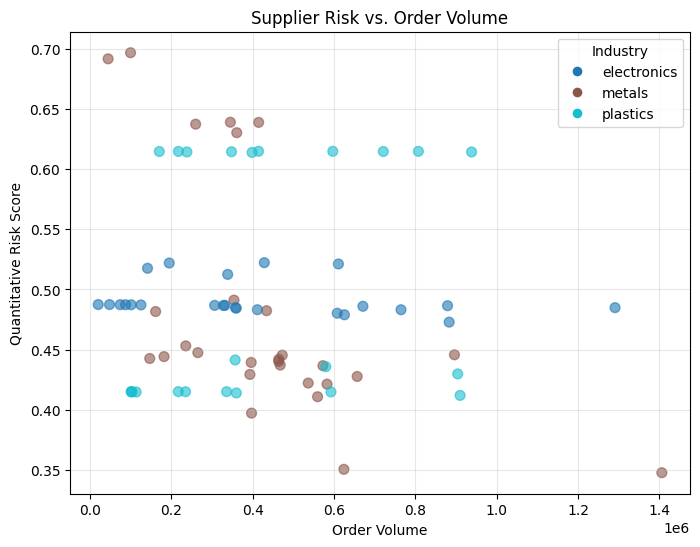

Plot saved to: /Users/annama/Documents/Tacto/Case Study/Code/data-engineering-challenge/reports/supplier_risk_vs_order_volume_by_industry.png


In [178]:
# Plot the correlation with industries as categories
# Map industries to numeric codes and colors
industries = df["industry"].astype("category")
industry_codes = industries.cat.codes
industry_labels = industries.cat.categories

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df["sum_of_order_volume"],
    df["quantitative_risk_score"],
    alpha=0.6,
    c=industry_codes,
    cmap="tab10",
    s=50
)

plt.xlabel("Order Volume")
plt.ylabel("Quantitative Risk Score")
plt.title("Supplier Risk vs. Order Volume")
plt.grid(True, alpha=0.3)

# Add legend
legend_handles = [plt.Line2D([0], [0], marker='o', color='w',
                             markerfacecolor=scatter.cmap(scatter.norm(code)),
                             markersize=8) for code in range(len(industry_labels))]
plt.legend(legend_handles, industry_labels, title="Industry")

plt.show()

# Save the plot 
REPORTS.mkdir(parents=True, exist_ok=True)
out_path = REPORTS / "supplier_risk_vs_order_volume_by_industry.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print(f"Plot saved to: {out_path}")
plt.close()

#### Interpretation:
The scatter plot shows the relationship between order volume and quantitative risk score, color-coded by industry. There is no strong correlation between order volume and risk (correlation ≈ –0.17), meaning that large suppliers are not necessarily more or less risky than smaller ones.

However, a pattern emerges:
- High-risk suppliers (risk > 0.60) are mostly in the metals and plastics industries.
- The electronics industry is more concentrated around mid-level risk scores (~0.45–0.55) with no extreme outliers.
- Metals suppliers show the widest spread in risk, from very low to very high, and also appear in both low- and high-volume categories.
- Plastics suppliers dominate the high-order-volume segment but also display some high-risk cases.

This suggests that risk mitigation efforts may need to focus particularly on certain metals and plastics suppliers rather than simply targeting the largest suppliers by spend.

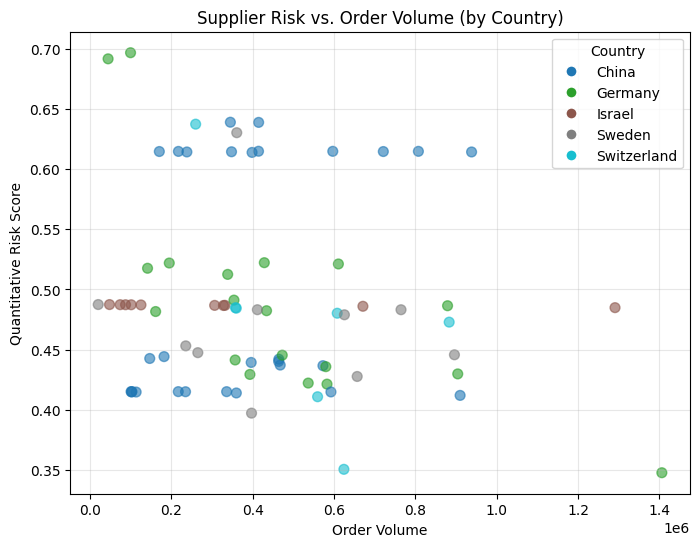

Plot saved to: /Users/annama/Documents/Tacto/Case Study/Code/data-engineering-challenge/reports/supplier_risk_vs_order_volume_by_country.png


In [179]:
# Plot the correlation with countries as categories

# Convert country column to categorical codes
countries_cat = df["country"].astype("category")
country_codes = countries_cat.cat.codes
country_labels = countries_cat.cat.categories

plt.figure(figsize=(8, 6))
scatter = plt.scatter(
    df["sum_of_order_volume"],
    df["quantitative_risk_score"],
    alpha=0.6,
    c=country_codes,
    cmap="tab10",
    s=50
)

plt.xlabel("Order Volume")
plt.ylabel("Quantitative Risk Score")
plt.title("Supplier Risk vs. Order Volume (by Country)")
plt.grid(True, alpha=0.3)


# Build legend
handles = [
    plt.Line2D([0], [0], marker="o", color="w",
               markerfacecolor=scatter.cmap(scatter.norm(i)),
               markersize=8)
    for i in range(len(country_labels))
]
plt.legend(handles, country_labels, title="Country", loc="best")

plt.show()

# Save the plot 
REPORTS.mkdir(parents=True, exist_ok=True)
out_path = REPORTS / "supplier_risk_vs_order_volume_by_country.png"
plt.savefig(out_path, dpi=300, bbox_inches="tight")
print(f"Plot saved to: {out_path}")
plt.close()

#### Interpretation:
Similar to the industry view, there is no clear correlation between order volume and risk, but geographic patterns emerge:
- Germany has several high-risk suppliers (risk > 0.65), all with low-to-mid order volumes. Interestingly, Germany also has the single lowest-risk, highest-volume supplier in the dataset.
- China displays a wider spread in risk, including both low- and high-risk suppliers, with many concentrated in the mid-volume range.
- Israel’s suppliers are tightly clustered around mid-risk scores (~0.48–0.50) regardless of order volume.
- Switzerland and Sweden show mixed risk levels, but none in the extreme high-risk category.
- High-risk suppliers appear in both developed markets (e.g., Germany) and emerging markets (e.g., China), suggesting that risk is not solely a function of geographic location.

In [167]:
# 3) Average risk per country and per industry
avg_risk_country = df.groupby("country").agg(
    avg_risk=("quantitative_risk_score", "mean"),
    total_volume=("sum_of_order_volume", "sum"),
    supplier_count=("supplier_id", "count")
).sort_values("avg_risk", ascending=False).round(3)

avg_risk_industry = df.groupby("industry").agg(
    avg_risk=("quantitative_risk_score", "mean"),
    total_volume=("sum_of_order_volume", "sum"),
    supplier_count=("supplier_id", "count")
).sort_values("avg_risk", ascending=False).round(3)

print("Average risk per country:\n", avg_risk_country, "\n")
print("Average risk per industry:\n", avg_risk_industry, "\n")


Average risk per country:
              avg_risk  total_volume  supplier_count
country                                            
China           0.505   11380823.71              29
Germany         0.489    8922946.80              19
Israel          0.487    3367021.19              10
Switzerland     0.474    3653286.73               7
Sweden          0.473    4635597.27              10 

Average risk per industry:
              avg_risk  total_volume  supplier_count
industry                                           
plastics        0.504    9766531.77              23
electronics     0.492    9993551.07              24
metals          0.481   12199592.86              28 



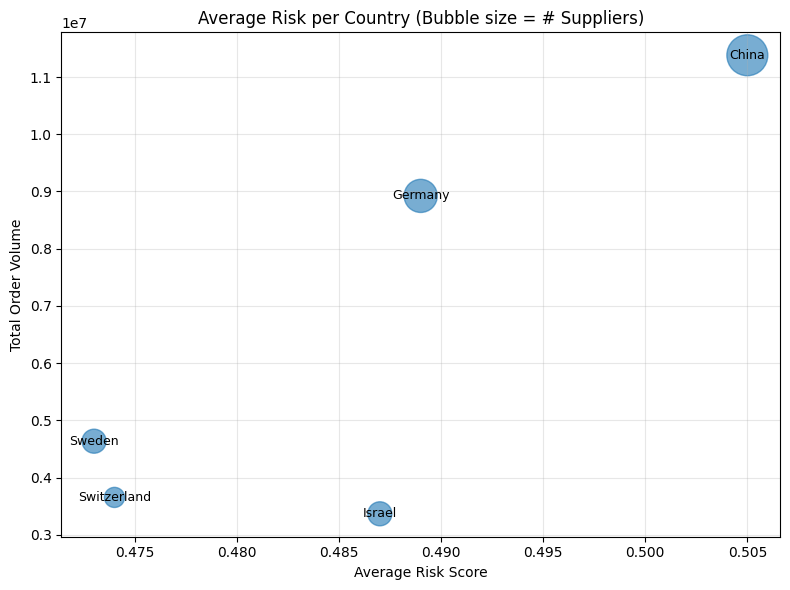

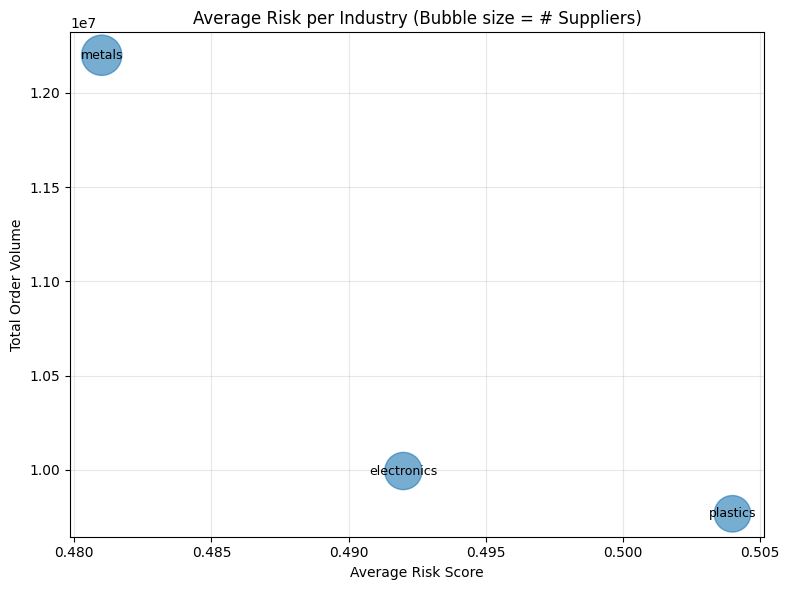

In [182]:
# Plot the results
# Path to save plots
REPORTS = PROJ / 'reports'
REPORTS.mkdir(parents=True, exist_ok=True)

def plot_bubble(df, title, filename):
    plt.figure(figsize=(8, 6))
    plt.scatter(
        df['avg_risk'],
        df['total_volume'],
        s=df['supplier_count'] * 30,  # bubble size
        alpha=0.6
    )
    for label, row in df.iterrows():
        plt.text(row['avg_risk'], row['total_volume'], label, fontsize=9,
                 ha='center', va='center')
    plt.xlabel("Average Risk Score")
    plt.ylabel("Total Order Volume")
    plt.title(f"{title} (Bubble size = # Suppliers)")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.savefig(REPORTS / filename, dpi=300)
    plt.show()

# Plot average risk per country
plot_bubble(avg_risk_country, "Average Risk per Country", "avg_risk_per_country.png")

# Plot average risk per industry
plot_bubble(avg_risk_industry, "Average Risk per Industry", "avg_risk_per_industry.png")

#### Interpretation of average risk per country/industry
By country:
- China has the highest average quantitative risk score (0.505) and also the highest total order volume (~11.38M).
- This combination means China is a key spend country with above-average risk, so suppliers from China could have a bigger impact on overall portfolio risk.
- Germany is second in total spend and has a slightly below-China risk score (0.489), indicating domestic suppliers are not necessarily low-risk.
- Switzerland and Sweden show both lower average risk scores and smaller supplier counts, making them lower-priority for risk mitigation if resources are limited.

By industry:
- Plastics has the highest average risk score (0.504) despite having fewer suppliers than metals, suggesting this category may deserve targeted risk mitigation.
- Metals has the lowest average risk (0.481), but the largest total spend (~12.2M), so while the average risk is lower, the financial exposure is high.
- Electronics sits in the middle both in risk and total spend.

Focus the risk management efforts:
- High-risk + High-volume combinations (China, Plastics) → Top priority for supplier audits/mitigation.
- High-volume + Moderate-risk combinations (Metals) → Monitor closely due to potential large impact even if average risk is lower.

In [168]:
# 4) Risk factor profile by country/industry
# Mean risk factors per country (only top N countries by count)
risk_by_country = df.groupby("country")[["risk_hri", "risk_env", "risk_cert", "risk_revenue", "risk_industry"]].mean().round(3)
risk_by_country_top = risk_by_country.loc[df["country"].value_counts().head(5).index]

# Mean risk factors per industry
risk_by_industry = df.groupby("industry")[["risk_hri", "risk_env", "risk_cert", "risk_revenue", "risk_industry"]].mean().round(3)

print("Risk factor breakdown by country:\n", risk_by_country_top, "\n")
print("Risk factor breakdown by industry:\n", risk_by_industry, "\n")


Risk factor breakdown by country:
              risk_hri  risk_env  risk_cert  risk_revenue  risk_industry
country                                                                
China            0.61      0.27      0.414         0.987          0.362
Germany          0.13      0.96      0.105         0.774          0.532
Israel           0.02      0.91      0.000         0.995          0.700
Sweden           0.02      0.91      0.100         0.892          0.580
Switzerland      0.02      0.91      0.143         0.808          0.614 

Risk factor breakdown by industry:
              risk_hri  risk_env  risk_cert  risk_revenue  risk_industry
industry                                                               
electronics     0.048     0.922      0.000         0.962            0.7
metals          0.249     0.722      0.214         0.803            0.5
plastics        0.547     0.360      0.435         0.969            0.3 



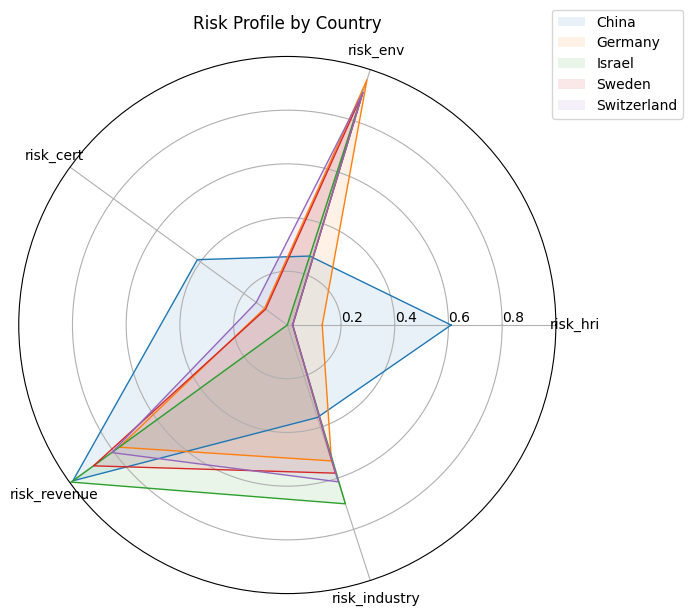

Saved: /Users/annama/Documents/Tacto/Case Study/Code/data-engineering-challenge/reports/radar_risk_by_country.png


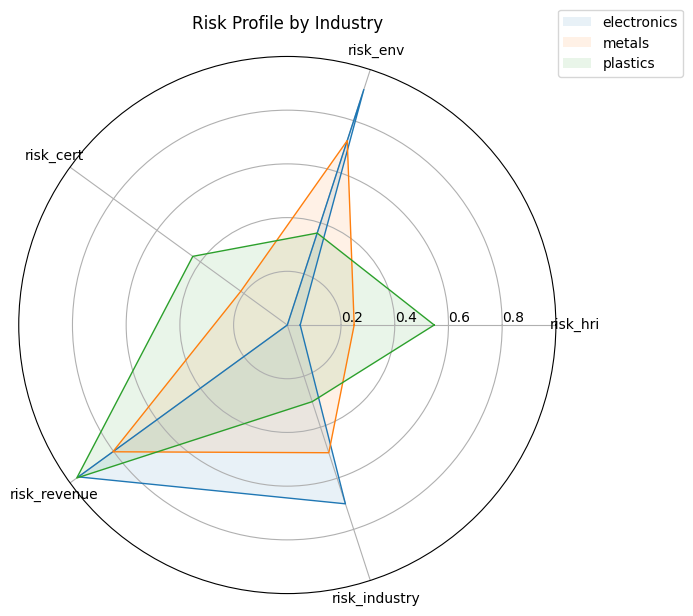

Saved: /Users/annama/Documents/Tacto/Case Study/Code/data-engineering-challenge/reports/radar_risk_by_industry.png


In [185]:
# Plot of risk factor profile by country/industry

REPORTS.mkdir(parents=True, exist_ok=True)

def plot_radar(df, title, filename):
    """
    df: rows = categories (e.g., countries or industries)
        cols = risk factor columns (e.g., risk_hri, risk_env, risk_cert, risk_revenue, risk_industry)
    """
    categories = list(df.columns)
    n_vars = len(categories)

    # Angles for each axis
    angles = np.linspace(0, 2*np.pi, n_vars, endpoint=False).tolist()
    angles += angles[:1]  # close the loop

    fig = plt.figure(figsize=(7, 7))
    ax = plt.subplot(111, polar=True)

    # Draw one axis per variable + add labels
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    ax.set_rlabel_position(0)
    ax.set_yticks([0.2, 0.4, 0.6, 0.8])
    ax.set_yticklabels(["0.2","0.4","0.6","0.8"])
    ax.set_ylim(0, 1)

    # Plot each row (category)
    for label, row in df.iterrows():
        values = row.tolist()
        values += values[:1]  # close loop
        ax.plot(angles, values, linewidth=1)
        ax.fill(angles, values, alpha=0.1, label=label)

    ax.set_title(title, pad=20)
    ax.legend(loc="upper right", bbox_to_anchor=(1.25, 1.10))
    plt.tight_layout()
    outpath = REPORTS / filename
    plt.savefig(outpath, dpi=300, bbox_inches="tight")
    plt.show()
    plt.close()
    print(f"Saved: {outpath}")

# Columns to include (order shown around the radar)
risk_cols = ["risk_hri", "risk_env", "risk_cert", "risk_revenue", "risk_industry"]

# Radar: top countries by count (you already limited to 5)
plot_radar(
    risk_by_country_top[risk_cols],
    title="Risk Profile by Country",
    filename="radar_risk_by_country.png"
)

# Radar: industries
plot_radar(
    risk_by_industry[risk_cols],
    title="Risk Profile by Industry",
    filename="radar_risk_by_industry.png"
)

#### Interpretation
By Country
- Countries with low HRI risk often have very high environmental risk.
- China stands out as the only country with high HRI risk in your top 5.
- Revenue risk is consistently high across countries — possibly meaning your scoring for this factor is skewed toward upper ranges.

By Industry
- Plastics is driven by HRI & certification risk.
- Electronics is driven almost entirely by environmental and industry risk.
- Metals is a more balanced profile, with all risks moderate but none extreme.

## Step 8: Next steps: 
#### How would you improve this MVP for Schmidt if you had more time & resources?
##### 1) Enhance data sources
- Integrate real-time supplier risk data feeds from external providers (e.g., sustainability ratings, geopolitical risk APIs, supply chain disruption alerts).
- Add financial health data (credit ratings, bankruptcy probability) and social media/news sentiment analysis to detect early warning signs.

##### 2) Refine scoring model
- Move from a static weighted average risk score to a machine learning–based risk prediction model, trained on historical supplier incidents.
- Use explainable AI to provide clear reasons for each supplier’s risk classification.

##### 3) Interactive dashboards
- Build a web-based dashboard (e.g., Streamlit, Power BI, or Tableau) so Schmidt can explore suppliers by country, industry, and risk factor, with dynamic filtering and drill-down views.
- Add scenario simulations (e.g., “What happens to my top 10 suppliers if environmental risk weight is doubled?”).

##### 4) Automated alerts
- Implement risk threshold monitoring with automated email/Slack alerts when a supplier moves into the high-risk zone.
- Schedule automated weekly reports to be sent to procurement managers.


#### 2) If you decided to scale this from 1 to 100+ customers – what would you change?
##### 1) Multi-tenancy architecture
- Host the tool as a secure cloud SaaS platform with separate workspaces per customer.
- Implement role-based access control for different procurement team members.

##### 2) Flexible configuration
- Allow each customer to customize risk factor weights, scoring thresholds, and which external data sources they connect.
- Support industry-specific risk templates.

##### 3) API-first design
- Expose all data and risk scoring through an API so customers can integrate it directly into their ERP or procurement systems (e.g., SAP, Oracle, Coupa).

##### 4) Automated data ingestion
- Build connectors for popular ERP, CRM, and procurement platforms to eliminate manual data uploads.
- Add scheduled background processing so data is always up-to-date.

##### 5) Scalable infrastructure
- Use distributed computing (e.g., Spark, Dask) for large datasets.
- Set up monitoring for API performance and automated scaling.

#### 3) What limitations could your MVP have?
##### 1) Static & limited scope
- Risk scores rely on current data snapshots; they don’t adapt in real-time to emerging events.
- Only a few risk dimensions are considered; other factors like political instability or cybersecurity risk are missing.

##### 2) Data quality dependency
- Results are highly dependent on the completeness and accuracy of Schmidt’s supplier, order, and risk data.

##### 3) Subjective weighting
- The current risk factor weights are hardcoded and subjective, not empirically validated for predictive accuracy.

##### 4) No causal insight
- The MVP tells you which suppliers are high risk, but not necessarily why beyond the individual factor averages.

##### 5) Limited user interface
- Outputs are mainly static CSV files and plots — not yet an interactive decision-support tool.

##### 6) Scalability constraints
- The current architecture might slow down or require significant rework for large, multi-customer deployments.